### Load các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

### Đọc dữ liệu từ file excel

In [3]:
df = pd.read_excel('data\Online_Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Tiền xử lý dữ liệu

In [4]:
# kiểm tra các giá trị bị thiếu
df.isnull().sum()

# loại bỏ các giá trị không hợp lệ
df.dropna(inplace=True)

#chuyển StockCode (mã sản phẩm) sang kiểu string
df['StockCode']= df['StockCode'].astype(str)

### Chia tập dữ liệu thành Train Data and Validation Data

In [5]:
customers = df['CustomerID'].unique().tolist()

# sắp xếp lại ngẫu nhiên các ID khách hàng
random.shuffle(customers)

# Chia tập dữ liệu gồm 90% train data   và 10% validation data
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# chia dữ liệu thành train data và validation data
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

### Tạo một chuỗi các sản phẩm đã mua của một khách hàng

In [6]:
# Tạo ra một list để nắm bắt lịch sử khách hàng( thực hiện trên tập train data)
purchases_train = []

# Với mỗi CustomerID sẽ ghi danh sách các mã sản phẩm đã mua của họ
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|█████████████████████████████████████████████████████████████████████████████| 3935/3935 [00:06<00:00, 572.36it/s]


In [7]:
# Tạo ra một list để nắm bắt lịch sử khách hàng( thực hiện trên tập validation data)
purchases_val = []

# Với mỗi CustomerID sẽ ghi danh sách các mã sản phẩm đã mua của họ
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)
import csv
with open('file.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(purchases_val)

100%|██████████████████████████████████████████████████████████████████████████████| 437/437 [00:00<00:00, 1106.33it/s]


### Xây dựng Word2Vec embeddings cho các mã sản phẩm

In [9]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3688987, 3726460)

In [8]:
model.init_sims(replace=True)
print(model)
model.wv.save_word2vec_format('model1.bin')
model.wv.save_word2vec_format('model1.txt', binary=False)

Word2Vec(vocab=3169, size=100, alpha=0.03)


### Các thông số của mô hình sau khi đã train

In [9]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3169, 100)

### Visualize word2vec embeddings bằng cách thu giảm số chiều sử dụng tSNE

In [10]:
from sklearn.manifold import TSNE

In [11]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

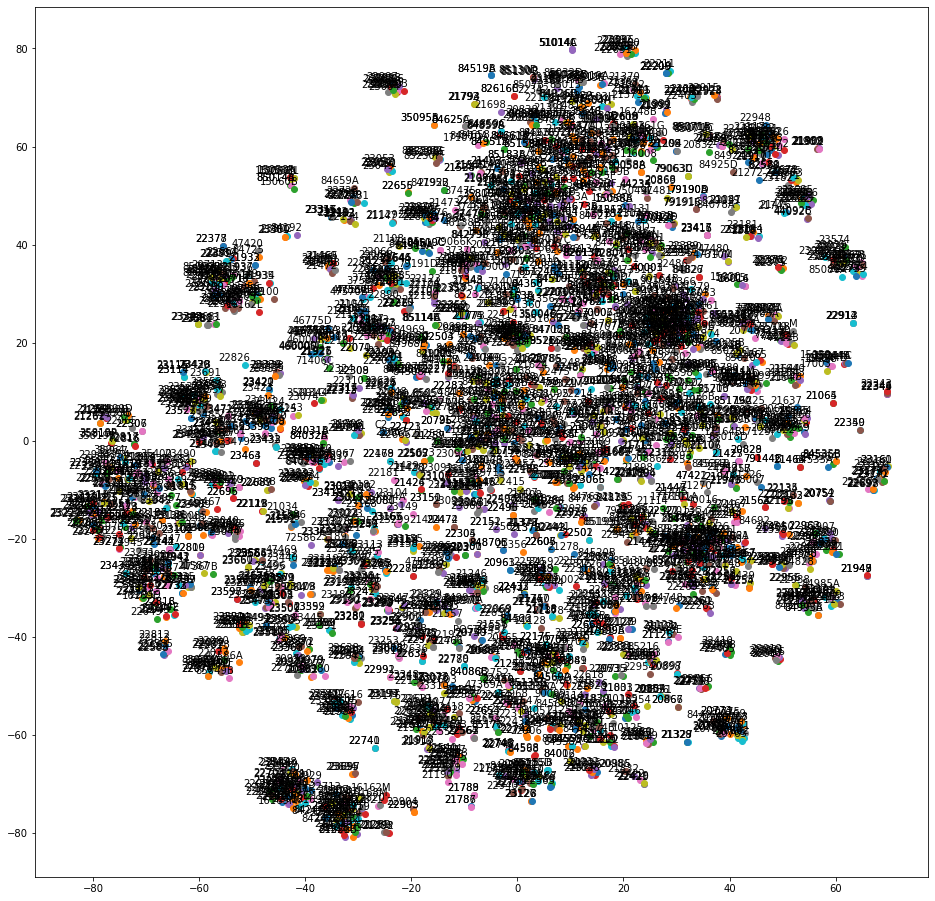

In [14]:
tsne_plot(model)

## Đề xuất sản phẩm

### Tạo danh sách gồm mã sản phẩm- tên sản phẩm

In [15]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

### Function trả về 6 sản tương tự với một sản phẩm cho trước

In [16]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms


### Tìm đề xuất cho một mã sản phẩm là 16218 ("CARTOON PENCIL SHARPENER")

In [17]:
similar_products(model['16218'])

[('LETTER SHAPE PENCIL SHARPENER', 0.7409214973449707),
 ('PIECE OF CAMO STATIONERY SET', 0.6811267137527466),
 ('HOUSE SHAPE PENCIL SHARPENER', 0.6737569570541382),
 ('TEATIME PUSH DOWN RUBBER', 0.6471887230873108),
 ('ASSORTED TUTTI FRUTTI KEYRING BALL', 0.642123281955719),
 ('POPART WOODEN PENCILS ASST', 0.6392998695373535)]

### Function trả về giá trị trung bình của các vector sản phẩm của một khách hàng đã mua

In [18]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

### Đề xuất sản phẩm dựa trên toàn bộ lịch sử mua hàng của khách hàng

In [19]:
similar_products(aggregate_vectors(purchases_val[8]))

[('LUNCH BAG RED RETROSPOT', 0.715409517288208),
 ('LUNCH BAG PINK POLKADOT', 0.704698920249939),
 ('JUMBO BAG RED RETROSPOT', 0.7036252617835999),
 ('JUMBO BAG WOODLAND ANIMALS', 0.7019925117492676),
 ('JUMBO STORAGE BAG SUKI', 0.6885334253311157),
 ('LUNCH BAG  BLACK SKULL.', 0.6877483129501343)]

In [20]:
# Đề xuất sản phẩm dựa trên 10 sản phẩm mua gần đây nhất
similar_products(aggregate_vectors(purchases_val[8][-10:]))

[('LUNCH BAG CARS BLUE', 0.8439152240753174),
 ('CHARLOTTE BAG VINTAGE ALPHABET ', 0.8151483535766602),
 ('LUNCH BAG SUKI DESIGN ', 0.8137177228927612),
 ('LUNCH BAG PINK POLKADOT', 0.8111310005187988),
 ('LUNCH BAG  BLACK SKULL.', 0.8063827753067017),
 ('RED RETROSPOT CHARLOTTE BAG', 0.8040826320648193)]